In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os

Preparing data

In [ ]:
dataPath  = "/content/drive/MyDrive/CSE_584_Dataset/CSE_584_dataset"
csv_files = [f for f in os.listdir(dataPath) if f.endswith('.csv')]


df_list = []


for file in csv_files:
    file_path = os.path.join(dataPath, file)
    df = pd.read_csv(file_path)
    df_list.append(df)


rawData = pd.concat(df_list, ignore_index=True)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/concatenated_top_p(1).csv')


unique_values = df['top_p'].unique()


dataframes = {}


for value in unique_values:
    dataframes[value] = df[df['top_p'] == value]

# Example: Access a specific DataFrame by value
# df_value_a = dataframes['value_a']

# Print the DataFrames (optional)
for key, dataframe in dataframes.items():
    print(f"DataFrame for x = {key}:")
    print(dataframe)
    print("\n")  # New line for better readability


DataFrame for x = 0.2:
                                                   Xi  \
0   Thequestionofhowhuman decision-makersdetermine...   
1   informed by na turalistic p riors . The agent ...   
2   Classification problems are central to many ap...   
3   Lifelong learning policies aim to create a ski...   
4         Bayesian methods are widely used in machine   
20  Thequestionofhowhuman decision-makersdetermine...   
21  informed by na turalistic p riors . The agent ...   
22  Classification problems are central to many ap...   
23  Lifelong learning policies aim to create a ski...   
24        Bayesian methods are widely used in machine   
40  Thequestionofhowhuman decision-makersdetermine...   
41  informed by na turalistic p riors . The agent ...   
42  Classification problems are central to many ap...   
43  Lifelong learning policies aim to create a ski...   
44        Bayesian methods are widely used in machine   
60  Thequestionofhowhuman decision-makersdetermine...   
61  info

In [ ]:
dataframes.keys()

dict_keys([0.2, 0.4, 0.6, 0.8])

In [ ]:
rawData = dataframes[0.8]

In [ ]:
data_cleaned = rawData.dropna(subset=['Xj'])


In [ ]:
dataDict = data_cleaned.to_dict(orient='list')
dataDict.keys()

dict_keys(['Xi', 'Xj', 'model', 'temperature', 'top_p', 'top_k', 'max_output_tokens', 'percentage_ai_count'])

In [ ]:
data = {}

data['text1'] = dataDict['Xi']
data['text2'] = dataDict['Xj']

uniqueLabels = set(dataDict['model'])
labelMap = {}
lbs = {'llama3.2:latest': 1, 'mistral:latest': 2, 'gemini': 3, 'llama_3.1': 4, 'qwen2.5:latest': 5}
for lb in uniqueLabels:
  labelMap[lb] = lbs[lb]
  id+=1

print(labelMap)

data['label'] = [labelMap[i] for i in dataDict['model']]


{'llama3.2:latest': 1, 'mistral:latest': 2, 'gemini': 3, 'qwen2.5:latest': 5}


In [ ]:
dataset = Dataset.from_dict(data)

In [ ]:
train_test_split_ratio = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split_ratio['train']
val_dataset = train_test_split_ratio['test']


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(examples):
    return tokenizer(examples['text1'], examples['text2'], padding='max_length', truncation=True)




/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
#train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
#train_dataset = train_dataset.remove_columns(['text1', 'text2'])
val_dataset = val_dataset.remove_columns(['text1', 'text2'])

Model initialization

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(uniqueLabels))


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
et = torch.load('/content/drive/MyDrive/checkpoints/epoch_6.pt', map_location=torch.device('cpu'))

<ipython-input-18-2d404ea5ac60>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  et = torch.load('/content/drive/MyDrive/checkpoints/epoch_6.pt', map_location=torch.device('

In [ ]:
from evaluate import load as load_metric
metric = load_metric("accuracy")
import numpy as np


import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    if isinstance(logits, np.ndarray):
        logits = torch.tensor(logits)


    predictions = torch.argmax(logits, dim=-1)


    return metric.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    logging_steps = 1,
    logging_dir = "/content/drive/MyDrive/checkpoints",
    weight_decay=0.01,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset= val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.519100,0.637067,0.730618


Epoch,Training Loss,Validation Loss,Accuracy
1,0.519100,0.637067,0.730618
2,0.824000,0.562900,0.785995


KeyboardInterrupt: 

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("/content/content/drive/MyDrive/checkpoints/roberta-text-classification")

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


model.eval()


val_texts = val_dataset['text']
true_labels = val_dataset['label']

# Tokenize the validation texts
inputs = tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)


with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).numpy()

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RoBERTa Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


KeyError: "Column text not in the dataset. Current columns in the dataset: ['label', 'input_ids', 'attention_mask']"

Evaluation

In [ ]:
trainer.evaluate() #0.2, 0.4 => 0.6,0.7

{'eval_loss': 0.7510122656822205,
 'eval_model_preparation_time': 0.0096,
 'eval_accuracy': 0.7,
 'eval_runtime': 0.6723,
 'eval_samples_per_second': 29.748,
 'eval_steps_per_second': 4.462}

In [ ]:
trainer.evaluate() #0.6

{'eval_loss': 0.8575853109359741,
 'eval_model_preparation_time': 0.0062,
 'eval_accuracy': 0.6,
 'eval_runtime': 0.6642,
 'eval_samples_per_second': 30.111,
 'eval_steps_per_second': 4.517}

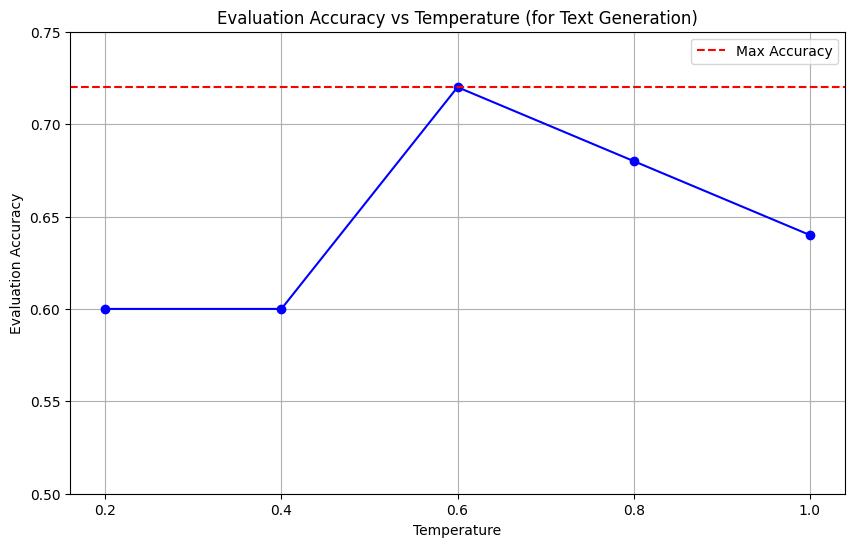

In [ ]:
import matplotlib.pyplot as plt


temperatures = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = [0.6, 0.6, 0.72, 0.68, 0.64]


plt.figure(figsize=(10, 6))
plt.plot(temperatures, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Evaluation Accuracy vs Temperature (for Text Generation)')
plt.xlabel('Temperature')
plt.ylabel('Evaluation Accuracy')
plt.xticks(temperatures)
plt.ylim(0.5, 0.75)
plt.grid()
plt.axhline(y=max(accuracies), color='r', linestyle='--', label='Max Accuracy')
plt.legend()
plt.show()


In [ ]:
trainer.evaluate() #0.8

{'eval_loss': 0.8186162710189819,
 'eval_model_preparation_time': 0.0059,
 'eval_accuracy': 0.65,
 'eval_runtime': 0.6716,
 'eval_samples_per_second': 29.778,
 'eval_steps_per_second': 4.467}

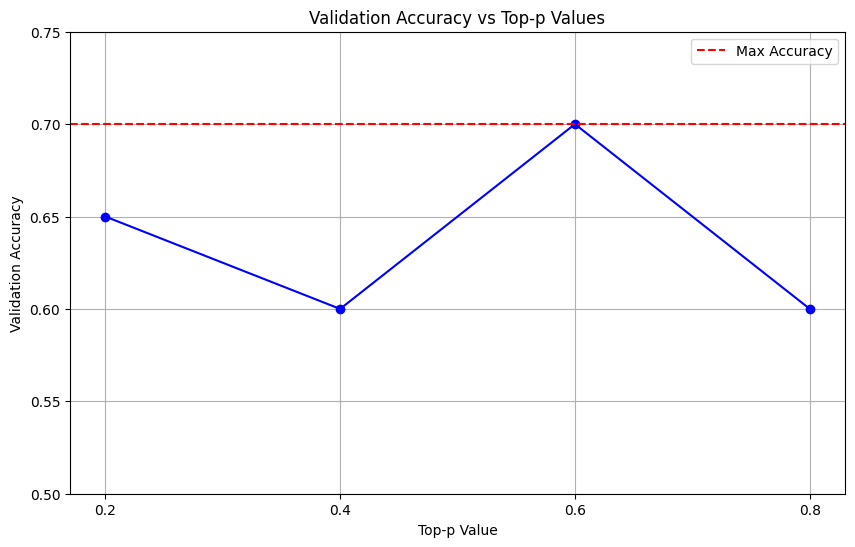

In [ ]:
import matplotlib.pyplot as plt

# Define the top-p values and corresponding accuracies
top_p_values = [0.8, 0.6, 0.4, 0.2]
accuracies = [0.6, 0.7, 0.6, 0.65]


plt.figure(figsize=(10, 6))
plt.plot(top_p_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Validation Accuracy vs Top-p Values')
plt.xlabel('Top-p Value')
plt.ylabel('Validation Accuracy')
plt.xticks(top_p_values)
plt.ylim(0.5, 0.75)
plt.grid()
plt.axhline(y=max(accuracies), color='r', linestyle='--', label='Max Accuracy')
plt.legend()
plt.savefig('top_p_accuracy.png')
plt.show()


In [ ]:
trainer.evaluate() #1.0

{'eval_loss': 0.999595046043396,
 'eval_model_preparation_time': 0.0054,
 'eval_accuracy': 0.64,
 'eval_runtime': 0.8316,
 'eval_samples_per_second': 30.063,
 'eval_steps_per_second': 4.81}

In [ ]:
trainer.evaluate() #20

{'eval_loss': 1.408810019493103,
 'eval_model_preparation_time': 0.0061,
 'eval_accuracy': 0.48,
 'eval_runtime': 0.8553,
 'eval_samples_per_second': 29.23,
 'eval_steps_per_second': 4.677}

In [ ]:
trainer.evaluate() #15

{'eval_loss': 1.5492613315582275,
 'eval_model_preparation_time': 0.0093,
 'eval_accuracy': 0.56,
 'eval_runtime': 0.8417,
 'eval_samples_per_second': 29.701,
 'eval_steps_per_second': 4.752}

In [ ]:
trainer.evaluate() #10

{'eval_loss': 1.4352928400039673,
 'eval_model_preparation_time': 0.0138,
 'eval_accuracy': 0.56,
 'eval_runtime': 0.8396,
 'eval_samples_per_second': 29.774,
 'eval_steps_per_second': 4.764}

In [ ]:
trainer.evaluate() #5

{'eval_loss': 1.6626362800598145,
 'eval_model_preparation_time': 0.0077,
 'eval_accuracy': 0.6,
 'eval_runtime': 0.8927,
 'eval_samples_per_second': 28.006,
 'eval_steps_per_second': 4.481}

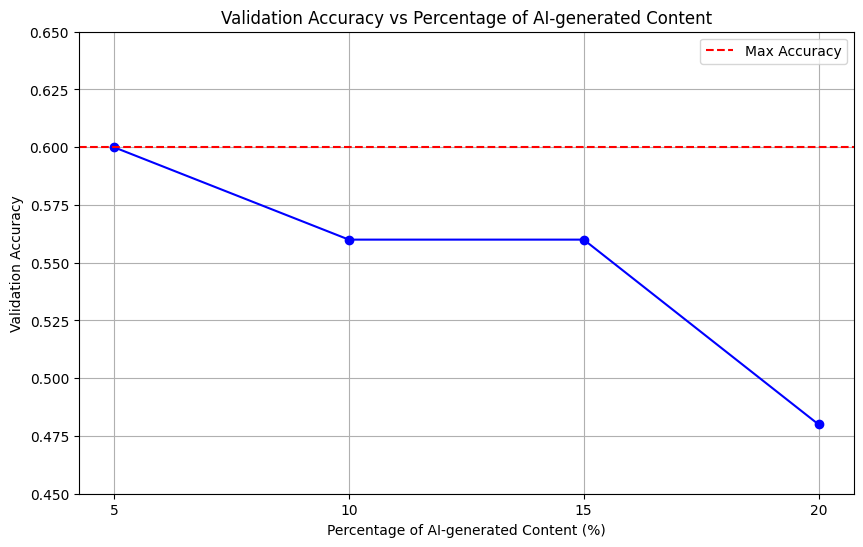

In [ ]:
import matplotlib.pyplot as plt

# Define the percentages of AI-generated content and corresponding accuracies
ai_generated_percentages = [5, 10, 15, 20]
accuracies = [0.6, 0.56, 0.56, 0.48]


plt.figure(figsize=(10, 6))
plt.plot(ai_generated_percentages, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Validation Accuracy vs Percentage of AI-generated Content')
plt.xlabel('Percentage of AI-generated Content (%)')
plt.ylabel('Validation Accuracy')
plt.xticks(ai_generated_percentages)
plt.ylim(0.45, 0.65)
plt.grid()
plt.axhline(y=max(accuracies), color='r', linestyle='--', label='Max Accuracy')
plt.legend()
plt.savefig('ai_generated_accuracy.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.sum(preds == labels) / len(labels)
    return {
        'accuracy': accuracy,
        'loss': pred.loss,
    }

# training arguments (for evaluation)
training_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    logging_dir='./logs',
)



Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Include the compute_metrics function
)

# Evaluation
evaluation_results = trainer.evaluate()

# Print accuracy and loss
accuracy = evaluation_results.get('eval_accuracy', None)
loss = evaluation_results.get('eval_loss', None)

print(f"Evaluation Loss: {loss:.4f}")
print(f"Evaluation Accuracy: {accuracy:.4f}")





In [ ]:
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tokenizer
#model = RobertaForSequenceClassification.from_pretrained('path_to_your_model').to(device)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # or your specific model

model.eval()


#single_sample_text = "People moving by a	busy street often seem like blurs. "
#single_sample_text = "a man is carrying a load	on his back, struggling to maintain his balance."
single_sample_text = "Two people ride their yellow bikes on water"


inputs = tokenizer(single_sample_text, return_tensors="pt").to(device)


with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits


predicted_class = np.argmax(logits.cpu().numpy(), axis=1)

print(f"Predicted class: {predicted_class[0]}")


Predicted class: 0


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(accuracy)

None


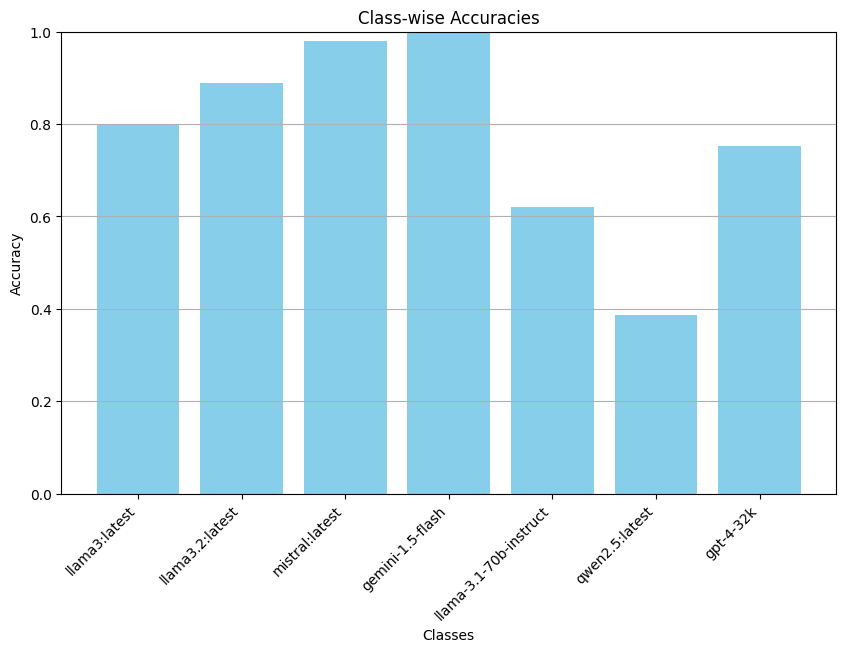

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# true_labels = predictions.label_ids
# predicted_labels = np.argmax(predictions.predictions, axis=1)

# confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# class-wise accuracies
class_accuracies = cm.diagonal() / cm.sum(axis=1)


class_names = ['llama3:latest', 'llama3.2:latest', 'mistral:latest',
               'gemini-1.5-flash', 'llama-3.1-70b-instruct', 'qwen2.5:latest',
               'gpt-4-32k']


plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.ylim(0, 1)
plt.title('Class-wise Accuracies')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [ ]:
model.save_pretrained("./content/drive/MyDrive/checkpoints/roberta-text-classification")

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


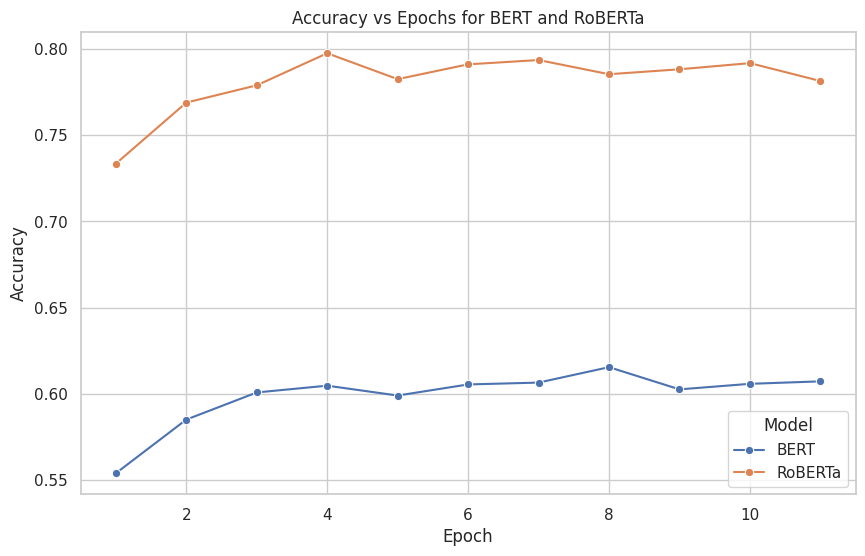

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


bert_accuracies = [0.554126, 0.585209, 0.600929, 0.604859, 0.599143,
                   0.605573, 0.606645, 0.615577, 0.602715, 0.605931, 0.607360]

roberta_accuracies = [0.733476, 0.768846, 0.778850, 0.797428, 0.782422,
                      0.790997, 0.793498, 0.785280, 0.788139, 0.791711, 0.781350]


epochs_bert = list(range(1, len(bert_accuracies) + 1))
epochs_roberta = list(range(1, len(roberta_accuracies) + 1))


data = pd.DataFrame({
    'Epoch': epochs_bert + epochs_roberta,
    'Accuracy': bert_accuracies + roberta_accuracies,
    'Model': ['BERT'] * len(bert_accuracies) + ['RoBERTa'] * len(roberta_accuracies)
})


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Accuracy', hue='Model', data=data, marker='o')


plt.title('Accuracy vs Epochs for BERT and RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.show()


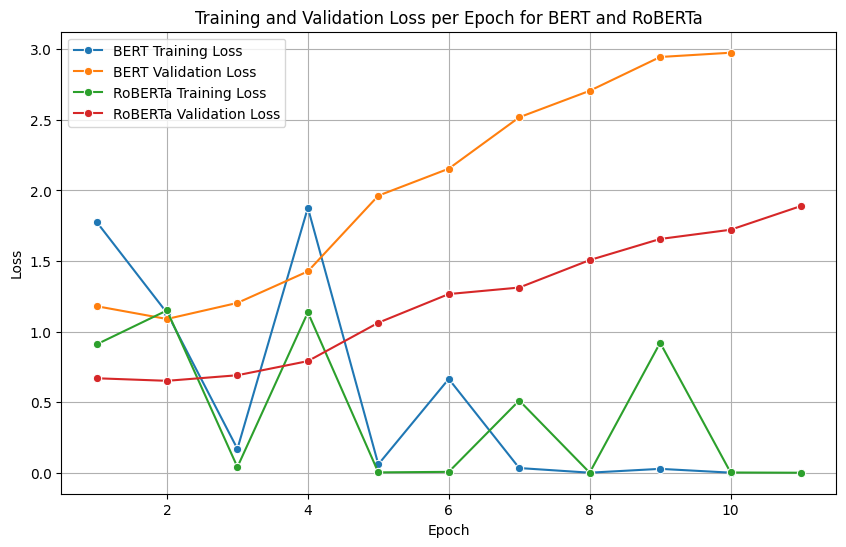

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for BERT
bert_data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Training Loss': [1.778400, 1.132800, 0.169300, 1.877600, 0.059600, 0.664700, 0.033300, 0.000500, 0.027600, 0.000700],
    'Validation Loss': [1.180204, 1.089391, 1.203426, 1.426889, 1.963232, 2.154499, 2.518505, 2.706300, 2.945846, 2.976062]
}

# Data for RoBERTa
roberta_data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Training Loss': [0.909300, 1.150200, 0.040400, 1.136300, 0.002600, 0.006400, 0.511800, 0.000600, 0.921000, 0.001800, 0.000200],
    'Validation Loss': [0.669506, 0.651383, 0.690859, 0.791005, 1.063000, 1.266176, 1.312213, 1.506748, 1.656405, 1.721825, 1.890004]
}


bert_df = pd.DataFrame(bert_data)
roberta_df = pd.DataFrame(roberta_data)


plt.figure(figsize=(10, 6))

# BERT Training and Validation Loss
sns.lineplot(x='Epoch', y='Training Loss', data=bert_df, marker='o', label='BERT Training Loss')
sns.lineplot(x='Epoch', y='Validation Loss', data=bert_df, marker='o', label='BERT Validation Loss')

# RoBERTa Training and Validation Loss
sns.lineplot(x='Epoch', y='Training Loss', data=roberta_df, marker='o', label='RoBERTa Training Loss')
sns.lineplot(x='Epoch', y='Validation Loss', data=roberta_df, marker='o', label='RoBERTa Validation Loss')


plt.title('Training and Validation Loss per Epoch for BERT and RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
